# Code for generating plots in paper

In [1]:
%matplotlib inline
import matplotlib

In [2]:
import csv
import numpy as np
import pandas as pd
matplotlib.style.use('seaborn')
import seaborn as sns
sns.color_palette("Paired")
import matplotlib.pyplot as plt
from copy import deepcopy
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot

## Code for generating figures 3 and 4

### Figuer 3

In [3]:
cubic = ["W","V","K","Al","Cu","Pd"]
hcp = ["Ti","Re","Y"]
metals = cubic+hcp

In [8]:
def make_scatter_plot_data(data_frame):
    """Converts the data in the dataframe from it's read in format 
    to the format needed for plotting. Which entails dropping the 
    `mean` and `count` columns from the data."""
    rows = np.asarray(data_frame.index)
    
    data = []
    for row in rows:
        temp = data_frame.ix[:,data_frame.columns.difference(["mean","count"])].loc[row].dropna().values
        for t in temp:
            data.append([float(row),t])
            
    return np.array(data)
        

In [4]:
def get_mean_data_kpd(method,elements,sub_method=None):
    """Gathers the convergence data for the given method, element, 
    and sub-method, i.e. 'sc' for the Froyen method, and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different k-point density. The dataframe also
    contains the mean error per density and numbder of times 
    the density occures.
    
    Args:
        methad (str): "Froyen", "Mueller", or "Aflow"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    for el in elements: # loop over element types
        if el in ["Ti","Y","Re"]:
            sizes = range(1,8)
        else:
            sizes = range(1,12)
            
        for i in sizes: # loop over element sizes
            data = []
            kpd = []
            # read the file
            if sub_method is None:
                f = open("../data2/{0}/{1}_conv/{2}_atom_kpd_conv.csv".format(method,el,i),"r")
            else:
                f = open("../data2/{0}/{1}_conv/{2}_{3}_atom_kpd_conv.csv".format(method,el,i,sub_method),"r")
            reader = csv.reader(f,delimiter='\t')
            # parse the file for the data, if this k-point density has occured before 
            # then we take the average of the errors reported (this is rare), otherwise
            # we just add it to the dataframe.
            for row in reader:
                # if the system is hcp we need to divide the answeres by 2
                # in order to get error per atom instead of error per cell.
                if el in ["Ti","Re","Y"]:
                    if float(row[0]) in kpd and float(row[1]) >= 1E-6:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+(float(row[1])/2.))/2.
                    elif float(row[1]) >= 1E-6:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])/2.]
                        data.append(point)                    
                else:
                    if float(row[0]) in kpd and float(row[1]) >= 1E-6:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+float(row[1]))/2.
                    elif float(row[1]) >= 1E-6:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])]
                        data.append(point)
                    
            data = np.array(data)
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])#,columns=[str(i)+' atom'])    
            else:
                # If there was no usable data for an element size print a warning
                print("Method: {0}, element: {1}, size: {2} had no useable "
                      "data".format(method,el,i))
                
            # if the dataframe already exists then add to it, otherwise save the dataframe.
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df

    # find the mean and number of instances for each row. (across element types and cell sizes)
    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf

In [5]:
# get the data
M_metals = get_mean_data_kpd("Mueller", metals)
F_sc_metals = get_mean_data_kpd("Froyen", cubic, sub_method="sc")
F_bcc_metals = get_mean_data_kpd("Froyen", cubic, sub_method="bcc")
F_fcc_metals = get_mean_data_kpd("Froyen", cubic, sub_method="fcc")
F_hcp_metals = get_mean_data_kpd("Froyen", hcp, sub_method="hcp")
A_metals = get_mean_data_kpd("Aflow", metals)

Method: Froyen, element: V, size: 1
Method: Froyen, element: V, size: 1
Method: Froyen_VASP, element: V, size: 1
Method: Froyen_VASP, element: V, size: 1


In [13]:
# convert the data to the plotting format
M_metals_scat = make_scatter_plot_data(M_metals)
F_sc_metals_scat = make_scatter_plot_data(F_sc_metals)
F_bcc_metals_scat = make_scatter_plot_data(F_bcc_metals)
F_fcc_metals_scat = make_scatter_plot_data(F_fcc_metals)
F_hcp_metals_scat = make_scatter_plot_data(F_hcp_metals)
A_metals_scat = make_scatter_plot_data(A_metals)
# combine the Froyen datasets
F_metals_scat = np.concatenate((F_sc_metals_scat,F_bcc_metals_scat),axis=0)
F_metals_scat = np.concatenate((F_metals_scat,F_fcc_metals_scat),axis=0)
F_metals_scat = np.concatenate((F_metals_scat,F_hcp_metals_scat),axis=0)

In [7]:
def get_mean_data_ibzkpd(method,elements,sub_method=None):
    """Gathers the convergence data for the given method, element, 
    and sub-method, i.e. 'sc' for the Froyen method, and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different irreducible k-point density. 
    The dataframe also contains the mean error per density and
    numbder of times the density occures.
    
    Args:
        methad (str): "Froyen", "Mueller", or "Aflow"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    for el in elements:
        if el in ["Ti","Y","Re"]:
            sizes = range(1,8)
        else:
            sizes = range(1,12)
            
        for i in sizes:
            data = []
            kpd = []
            if sub_method is None:
                f = open("../data2/{0}/{1}_conv/{2}_atom_IBZKPTS_dese_conv.csv".format(method,el,i),"r")
            else:
                f = open("../data2/{0}/{1}_conv/{2}_{3}_atom_IBZKPTS_dese_conv.csv".format(method,el,i,sub_method),"r")
            reader = csv.reader(f,delimiter='\t')
            for row in reader:
                if el in ["Ti","Re","Y"]:
                    if float(row[0]) in kpd and float(row[1]) >= 1E-6:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+(float(row[1])/2.))/2.
                    elif float(row[1]) >= 1E-6:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])/2.]
                        data.append(point)                    
                else:
                    if float(row[0]) in kpd and float(row[1]) >= 1E-6:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+float(row[1]))/2.
                    elif float(row[1]) >= 1E-6:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])]
                        data.append(point)
                    
            data = np.array(data)
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])#,columns=[str(i)+' atom'])    
            else:
                print("Method: {0}, element: {1}, size: {2}".format(method,el,i))
                
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df

    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf

In [9]:
# Get the raw data from the files
M_metals_ibz = get_mean_data_ibzkpd("Mueller", metals)
F_sc_metals_ibz = get_mean_data_ibzkpd("Froyen", cubic, sub_method="sc")
F_bcc_metals_ibz = get_mean_data_ibzkpd("Froyen", cubic, sub_method="bcc")
F_fcc_metals_ibz = get_mean_data_ibzkpd("Froyen", cubic, sub_method="fcc")
F_hcp_metals_ibz = get_mean_data_ibzkpd("Froyen", hcp, sub_method="hcp")
A_metals_ibz = get_mean_data_ibzkpd("Aflow", metals)
U_metals_ibz = get_mean_data_ibzkpd("US", metals)

Method: Froyen, element: V, size: 1
Method: Froyen, element: V, size: 1
Method: Froyen_VASP, element: V, size: 1
Method: Froyen_VASP, element: V, size: 1


In [10]:
# convert the data to the format needed for plotting
M_metals_scat_ibz = make_scatter_plot_data(M_metals_ibz)
F_sc_metals_scat_ibz = make_scatter_plot_data(F_sc_metals_ibz)
F_bcc_metals_scat_ibz = make_scatter_plot_data(F_bcc_metals_ibz)
F_fcc_metals_scat_ibz = make_scatter_plot_data(F_fcc_metals_ibz)
F_hcp_metals_scat_ibz = make_scatter_plot_data(F_hcp_metals_ibz)
F_v_sc_metals_scat_ibz = make_scatter_plot_data(F_v_sc_metals_ibz)
A_metals_scat_ibz = make_scatter_plot_data(A_metals_ibz)
U_metals_scat_ibz = make_scatter_plot_data(U_metals_ibz)

In [11]:
# combine all the Froyen data types
F_metals_scat_ibz = np.concatenate((F_sc_metals_scat_ibz,F_bcc_metals_scat_ibz),axis=0)
F_metals_scat_ibz = np.concatenate((F_metals_scat_ibz,F_fcc_metals_scat_ibz),axis=0)
F_metals_scat_ibz = np.concatenate((F_metals_scat_ibz,F_hcp_metals_scat_ibz),axis=0)

In [14]:
np.savetxt("../R_workspace/Mueller_metals_ibz.csv",M_metals_scat_ibz,delimiter="\t")
np.savetxt("../R_workspace/Froyen_VASP_metals_ibz.csv",F_v_metals_scat_ibz,delimiter="\t")
np.savetxt("../R_workspace/Froyen_metals_ibz.csv",F_metals_scat_ibz,delimiter="\t")
np.savetxt("../R_workspace/Aflow_metals_ibz.csv",A_metals_scat_ibz,delimiter="\t")
np.savetxt("../R_workspace/US_metals_ibz.csv",U_metals_scat_ibz,delimiter="\t")

In [16]:
M_ibz_loess = 10**np.genfromtxt("../R_workspace/Muel_ibz_loess.csv",delimiter=",")[1:]
A_ibz_loess = 10**np.genfromtxt("../R_workspace/Aflow_ibz_loess.csv",delimiter=",")[1:]
F_ibz_loess = 10**np.genfromtxt("../R_workspace/Froyen_ibz_loess.csv",delimiter=",")[1:]
F_V_ibz_loess = 10**np.genfromtxt("../R_workspace/Froyen_VASP_ibz_loess.csv",delimiter=",")[1:]

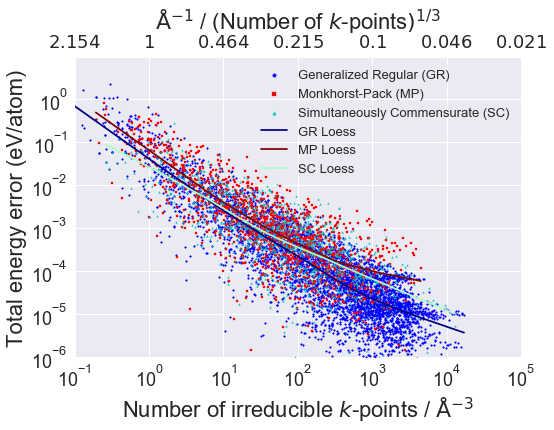

In [72]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
#ax3 = ax1.twiny()
 
ax1.scatter(M_metals_scat_ibz[:,0],abs(M_metals_scat_ibz[:,1]),
            label="Generalized Regular (GR)",marker="o",s=3,c='b')
ax1.scatter(A_metals_scat_ibz[:,0],abs(A_metals_scat_ibz[:,1]),
            label="Monkhorst-Pack (MP)",marker="s",s=3,c='r')
ax1.scatter(F_metals_scat_ibz[:,0],abs(F_metals_scat_ibz[:,1]),
            label="Simultaneously Commensurate (SC)",marker="^",s=3,c='c')
#ax1.scatter(U_metals_scat_ibz[:,0],abs(U_metals_scat_ibz[:,1]),label="Us",marker='*',s=5,c='k')
ax1.plot(M_ibz_loess[:,0],M_ibz_loess[:,1],label="GR Loess",c="#000080")
ax1.plot(A_ibz_loess[:,0],A_ibz_loess[:,1],label="MP Loess",c="#800000")
ax1.plot(F_ibz_loess[:,0],F_ibz_loess[:,1],label="SC Loess",c="#aaffc3")
ax1.set_xlabel("Number of irreducible $k$-points / $\mathrm{\AA}^{-3}$",
               fontsize=22)
ax1.set_xscale('log')

new_tick_locations = np.array([.1,1,10,100,1000,10000,100000])
def tick_function(X):
    V = 1/X
    return [np.log10(z) for z in V]
ax1.set_xlim(.1,100000)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xlabel("$\mathrm{\AA}^{-1}$ / (Number of $k$-points$)^{1/3}$",
              fontsize=22)
ax2.set_xscale('log')
ax2.set_xticklabels(["1.00","$2.154$","$1$","$0.464$",
                    "$0.215$","$0.1$","$0.046$","$0.021$"],fontsize=18)
ax2.grid(False)

#ax3.set_xlim((.1,100000))
#ax3.set_xticks(new_tick_locations)
#ax3.set_xlabel("$\overline{R}$")
#ax3.set_xscale('log')
#ax3.set_xticklabels(["$2.9164$","$2.1964$","$6.28$","$13.53$",
#                    "$29.16$","$62.83$","$135.36$","$291.64$"])
#pos1 = ax2.get_position()
#pos2 = [pos1.x0,pos1.y0+0.015,pos1.width,pos1.height]
#ax2.set_position(pos2)
#ax2.grid(False)

ax1.set_ylabel("Total energy error (eV/atom)",fontsize=22)
#plt.title("Convergence of Metals",fontsize=24,y=1.125)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
plt.yscale('log')
plt.ylim(1E-6,9E0)
plt.xlim(1E-1,1E5)

handles,labels = ax1.get_legend_handles_labels()
handles = [handles[3],handles[4],handles[5],handles[0],handles[1],handles[2]]
labels = [labels[3],labels[4],labels[5],labels[0],labels[1],labels[2]]
ax1.legend(handles, labels, markerscale=2,fontsize=13)
#plt.savefig("../plots/Gen_MP_loess_ibz.pdf",bbox_inches="tight")
plt.savefig("../plots/All_metals_comb_irr.pdf",bbox_inches="tight")
#plt.savefig("../plots/US_MUEL_irr.pdf")
plt.show()

In [32]:
M_kpd_loess = 10**np.genfromtxt("../R_workspace/Muel_kpd_loess.csv",delimiter=",")[1:]
A_kpd_loess = 10**np.genfromtxt("../R_workspace/Aflow_kpd_loess.csv",delimiter=",")[1:]
F_kpd_loess = 10**np.genfromtxt("../R_workspace/Froyen_kpd_loess.csv",delimiter=",")[1:]
F_V_kpd_loess = 10**np.genfromtxt("../R_workspace/Froyen_VASP_kpd_loess.csv",delimiter=",")[1:]

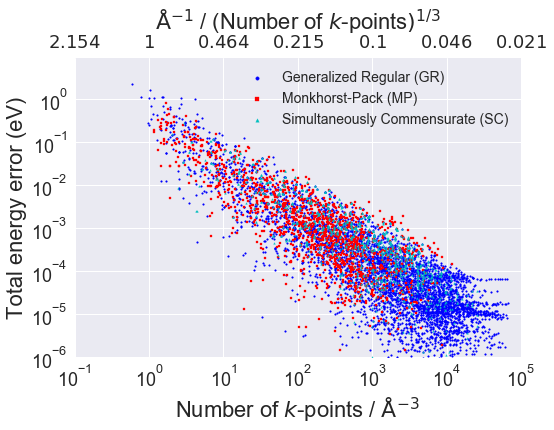

In [59]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
#ax3 = ax1.twiny()
 
ax1.scatter(M_metals_scat[:,0],abs(M_metals_scat[:,1]),
            label="Generalized Regular (GR)",marker="o",s=3,c='b')
#ax1.scatter(U_metals_scat[:,0],abs(U_metals_scat[:,1]),label="Us",marker="*",s=5,c='k')
ax1.scatter(A_metals_scat[:,0],abs(A_metals_scat[:,1]),
            label="Monkhorst-Pack (MP)",marker="s",s=3,c='r')
ax1.scatter(F_metals_scat[:,0],abs(F_metals_scat[:,1]),
            label="Simultaneously Commensurate (SC)", marker="^",s=3,c='c')
#ax1.plot(M_kpd_loess[:,0],M_kpd_loess[:,1],label="General Loess",c="#000080")
#ax1.plot(A_kpd_loess[:,0],A_kpd_loess[:,1],label="MP Loess",c="#800000")
#ax1.plot(F_kpd_loess[:,0],F_kpd_loess[:,1],label="Common Loess",c="#aaffc3")
ax1.set_xlabel("Number of $k$-points / $\mathrm{\AA}^{-3}$",fontsize=22)
ax1.set_xscale('log')

new_tick_locations = np.array([.1,1,10,100,1000,10000,100000])
def tick_function(X):
    V = 1/X
    return [np.log10(z) for z in V]
ax1.set_xlim(.1,100000)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xlabel("$\mathrm{\AA}^{-1}$ / (Number of $k$-points$)^{1/3}$",
               fontsize=22)
ax2.set_xscale('log')
ax2.set_xticklabels(["1.00","$2.154$","$1$","$0.464$",
                    "$0.215$","$0.1$","$0.046$","$0.021$"],fontsize=18)
ax2.grid(False)

#ax3.set_xlim((.1,100000))
#ax3.set_xticks(new_tick_locations)
#ax3.set_xlabel("$\overline{R}$")
#ax3.set_xscale('log')
#ax3.set_xticklabels(["$2.9164$","$2.1964$","$6.28$","$13.53$",
#                    "$29.16$","$62.83$","$135.36$","$291.64$"])
#pos1 = ax3.get_position()
#pos2 = [pos1.x0,pos1.y0+0.075,pos1.width,pos1.height]
#ax3.set_position(pos2)
#ax3.grid(False)

ax1.set_ylabel("Total energy error (eV)",fontsize=22)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
#plt.title("Convergence of Metals",fontsize=24,y=1.125)
plt.yscale('log')
plt.ylim(1E-6,9E0)
plt.xlim(1E-1,1E5)
ax1.legend(markerscale=2,fontsize=14)
plt.savefig("../plots/Mueller_metals_comb.pdf",bbox_inches="tight")
plt.show()

In [66]:
print(len(M_metals_scat),len(A_metals_scat),len(F_metals_scat))
print(len(M_metals_scat)+len(A_metals_scat)+len(F_metals_scat))

(4426, 1369, 1158)
6953


In [13]:
#metals = ["Al","Cu","K","Pd","V","W","Ti","Y","Re"]
Al_full = get_mean_data_full(["Al"])
Al_scat = make_scatter_plot_data(Al_full)
Al_1 = single_atom_scat("Al")
Cu_full = get_mean_data_full(["Cu"])
Cu_scat = make_scatter_plot_data(Cu_full)
Cu_1 = single_atom_scat("Cu")
K_full = get_mean_data_full(["K"])
K_scat = make_scatter_plot_data(K_full)
K_1 = single_atom_scat("K")
Pd_full = get_mean_data_full(["Pd"])
Pd_scat = make_scatter_plot_data(Pd_full)
Pd_1 = single_atom_scat("Pd")
V_full = get_mean_data_full(["V"])
V_scat = make_scatter_plot_data(V_full)
V_1 = single_atom_scat("K")
W_full = get_mean_data_full(["W"])
W_scat = make_scatter_plot_data(W_full)
W_1 = single_atom_scat("W")
Ti_full = get_mean_data_full(["Ti"])
Ti_scat = make_scatter_plot_data(Ti_full)
Ti_1 = single_atom_scat("Ti")
Y_full = get_mean_data_full(["Y"])
Y_scat = make_scatter_plot_data(Y_full)
Y_1 = single_atom_scat("Y")
Re_full = get_mean_data_full(["Re"])
Re_scat = make_scatter_plot_data(Re_full)
Re_1 = single_atom_scat("Re")
Si_full = get_mean_data_full(["Si"])
Si_scat = make_scatter_plot_data(Si_full)
Si_1 = single_atom_scat("Si")
NaCl_full = get_mean_data_full(["NaCl"])
NaCl_scat = make_scatter_plot_data(NaCl_full)
NaCl_1 = single_atom_scat("NaCl")

('element', 'Si', 'size', 7)
('element', 'NaCl', 'size', 5)
('element', 'NaCl', 'size', 6)
('element', 'NaCl', 'size', 7)


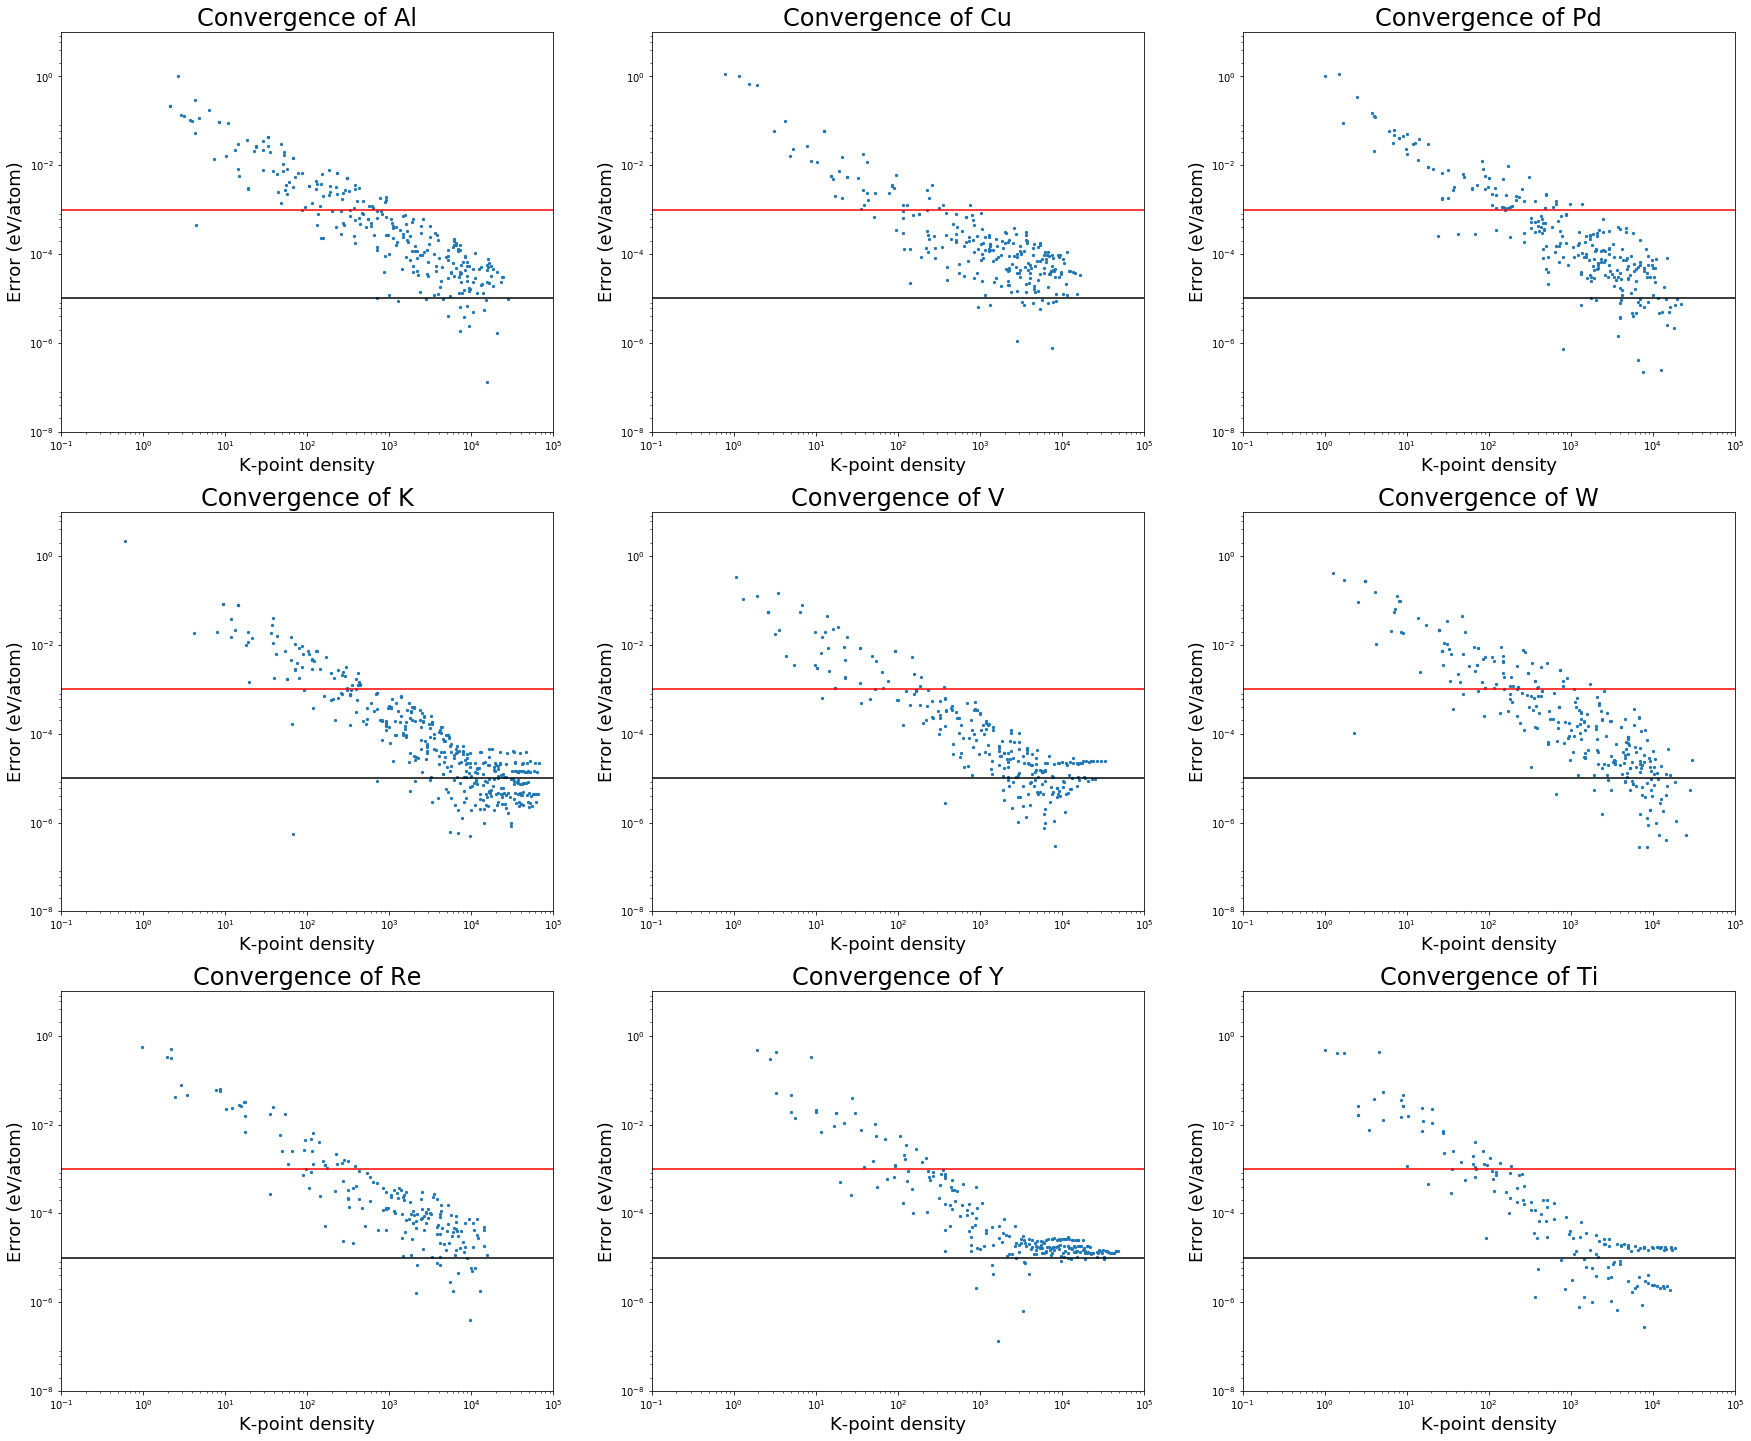

In [44]:
plt.figure(figsize=(30,25))
plt.subplot(3,3,1)
plt.scatter(Al_scat[:,0],Al_scat[:,1],label="Al",s=5)
#plt.scatter(Al_1[:,0],Al_1[:,1],label="Al 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Al",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,2)
plt.scatter(Cu_scat[:,0],Cu_scat[:,1],label="Cu",s=5)
#plt.scatter(Cu_1[:,0],Cu_1[:,1],label="Cu 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Cu",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,3)
plt.scatter(Pd_scat[:,0],Pd_scat[:,1],label="Pd",s=5)
#plt.scatter(Pd_1[:,0],Pd_1[:,1],label="Pd 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Pd",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,4)
plt.scatter(K_scat[:,0],K_scat[:,1],label="K",s=5)
#plt.scatter(K_1[:,0],K_1[:,1],label="K 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of K",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,5)
plt.scatter(V_scat[:,0],V_scat[:,1],label="V",s=5)
#plt.scatter(V_1[:,0],V_1[:,1],label="V 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of V",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,6)
plt.scatter(W_scat[:,0],W_scat[:,1],label="W",s=5)
#plt.scatter(W_1[:,0],W_1[:,1],label="W 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of W",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,7)
plt.scatter(Re_scat[:,0],Re_scat[:,1],label="Re",s=5)
#plt.scatter(Re_1[:,0],Re_1[:,1],label="Re 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Re",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,8)
plt.scatter(Y_scat[:,0],Y_scat[:,1],label="Y",s=5)
#plt.scatter(Y_1[:,0],Y_1[:,1],label="Y 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Y",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.subplot(3,3,9)
plt.scatter(Ti_scat[:,0],Ti_scat[:,1],label="Ti",s=5)
#plt.scatter(Ti_1[:,0],Ti_1[:,1],label="Ti 1 atom",s=3)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Ti",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,1E1)
plt.xlim(1E-1,1E5)
plt.savefig("../plots/metal_dense_conv_by_element.pdf")
plt.show()

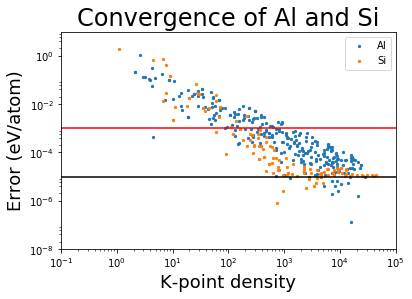

In [43]:
plt.scatter(Al_scat[:,0],Al_scat[:,1],label="Al",s=5)
#plt.scatter(Ti_scat[:,0],Ti_scat[:,1],label="Ti",s=3)
#plt.scatter(Cu_scat[:,0],Cu_scat[:,1],label="Cu",s=3)
#plt.scatter(Pd_scat[:,0],Pd_scat[:,1],label="Pd",s=3)
#plt.scatter(Re_scat[:,0],Re_scat[:,1],label="Re",s=3)
#plt.scatter(K_scat[:,0],K_scat[:,1],label="K",s=3)
#plt.scatter(V_scat[:,0],V_scat[:,1],label="V",s=3)
#plt.scatter(W_scat[:,0],W_scat[:,1],label="W",s=3)
#plt.scatter(Y_scat[:,0],Y_scat[:,1],label="Y",s=3)
plt.scatter(Si_scat[:,0],Si_scat[:,1],label="Si",s=5)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Al and Si",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,10)
plt.xlim(1E-1,1E5)
plt.legend(loc='upper right')
plt.savefig('/Users/wileymorgan/Desktop/Al_Si.pdf')
plt.show()

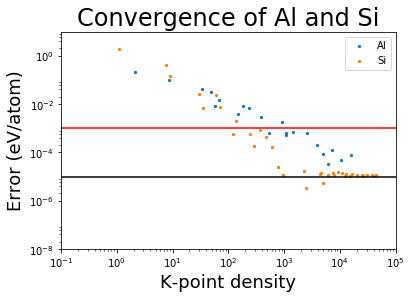

In [46]:
plt.scatter(Al_1[:,0],Al_1[:,1],label="Al",s=5)
plt.scatter(Si_1[:,0],Si_1[:,1],label="Si",s=5)
plt.axhline(y=1E-5, xmin=0, xmax=1, hold=None, c='k')
plt.axhline(y=1E-3, xmin=0, xmax=1, hold=None, c='r')
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("K-point density",fontsize=18)
plt.title("Convergence of Al and Si",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,10)
plt.xlim(1E-1,1E5)
plt.legend(loc='upper right')
plt.savefig('/Users/wileymorgan/Desktop/Al_Si.pdf')
plt.show()

In [137]:
valid_ks = [4, 32, 108, 256, 500, 864, 1024, 2048, 2000, 4000, 5324, 5488, 8788, 8192, 16384]

j_ks = []
m_j_ks = []
v54_ks = []
ks_u = []

f = open('../data2/Si_1/Si_Mueller_Rectangles')
reader = csv.reader(f,delimiter=' ')
for row in reader:
    if int(row[4]) in valid_ks:
        if int(row[4]) not in ks_u:
            ks_u.append(int(row[4]))
            j_ks.append([int(row[4]),float(row[3])])

ks_u = []
f = open('../data2/Si_1/Si_j_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    if int(row[0]) in valid_ks:
        if int(row[0]) not in ks_u:
            ks_u.append(int(row[0]))
            m_j_ks.append([int(row[0]),float(row[1])])

ks_u = []
f = open('../data2/Si_1/Si_j_V54_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    if int(row[0]) in valid_ks:
        if int(row[0]) not in ks_u:
            ks_u.append(int(row[0]))
            v54_ks.append([int(row[0]),float(row[1])])
            
v54_ks = np.array(v54_ks)
j_ks = np.array(j_ks)
m_j_ks = np.array(m_j_ks)

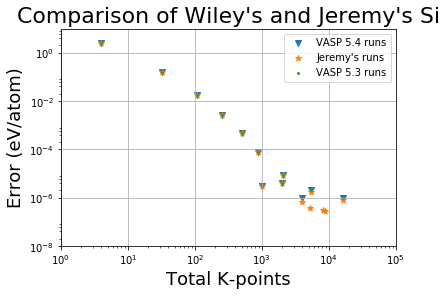

In [101]:
plt.scatter(v54_ks[:,0],v54_ks[:,1],label='VASP 5.4 runs',marker='v')
plt.scatter(j_ks[:,0],j_ks[:,1],label="Jeremy's runs",marker='*')
plt.scatter(m_j_ks[:,0],m_j_ks[:,1],label="VASP 5.3 runs",s=4)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,10)
plt.xlim(1E0,1E5)
plt.legend()
plt.grid()
plt.title("Comparison of Wiley's and Jeremy's Si",fontsize=22)
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("Total K-points",fontsize=18)
plt.savefig('/Users/wileymorgan/Desktop/Si_comparison.pdf')
plt.show()

In [138]:
ks_u = []
m_j_ks_all = []
f = open('../data2/Si_1/Si_j_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    if int(row[0]) not in ks_u:
        ks_u.append(int(row[0]))
        m_j_ks_all.append([int(row[0]),float(row[1])])
m_j_ks_all = np.array(m_j_ks_all)

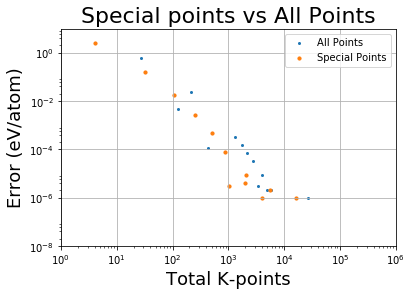

In [144]:
plt.scatter(m_j_ks_all[:,0],m_j_ks_all[:,1],label="All Points",s=4)
plt.scatter(m_j_ks[:,0],m_j_ks[:,1],label="Special Points",s=10)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-8,10)
plt.xlim(1E0,1E6)
plt.legend()
plt.grid()
plt.title("Special points vs All Points",fontsize=22)
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("Total K-points",fontsize=18)
plt.savefig('/Users/wileymorgan/Desktop/Si_special_points.pdf')
plt.show()

In [116]:
sc_a = [4*n**3 for n in range(1,41)]
fcc_a = [n**3 for n in range(1,61)]
bcc_a = [16*n**3 for n in range(1,26)]

In [315]:
sc = []
fcc = []
bcc = []
ks_u = []
f = open('../data2/Si_1/Si_j_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    if int(row[0]) not in ks_u and abs(float(row[1]))>0:
        ks_u.append(int(row[0]))
        if int(row[0]) in sc_a:            
            sc.append([int(row[0]),abs(float(row[1]))])
        elif int(row[0]) in fcc_a:
            fcc.append([int(row[0]),abs(float(row[1]))]) 
        elif int(row[0]) in bcc_a:
            bcc.append([int(row[0]),abs(float(row[1]))])
        else:
            print(row)
sc.sort(key=lambda x: x[0])
bcc.sort(key=lambda x: x[0])
fcc.sort(key=lambda x: x[0])
sc = np.array(sc)
bcc = np.array(bcc)
fcc = np.array(fcc)

In [132]:
def single_atom_scat_2(el):
    sc = []
    bcc = []
    fcc = []
    kpd = []
    f = open("../data2/{0}_conv/1_total_kps_atom_convergence.csv".format(el),"r")
    reader = csv.reader(f,delimiter='\t')
    for row in reader:
        if int(row[0]) not in kpd:
            kpd.append(int(row[0]))
            if int(row[0]) in sc_a:
                sc.append([int(row[0]),abs(float(row[1]))])
            elif int(row[0]) in fcc_a:
                fcc.append([int(row[0]),abs(float(row[1]))])
            elif int(row[0]) in bcc_a:
                bcc.append([int(row[0]),abs(float(row[1]))])
            else:
                print(row)
                break
    return np.array(sc), np.array(fcc), np.array(bcc)

In [159]:
al_sc, al_fcc, al_bcc = single_atom_scat_2("Al")
cu_sc, cu_fcc, cu_bcc = single_atom_scat_2("Cu")
pd_sc, pd_fcc, pd_bcc = single_atom_scat_2("Pd")

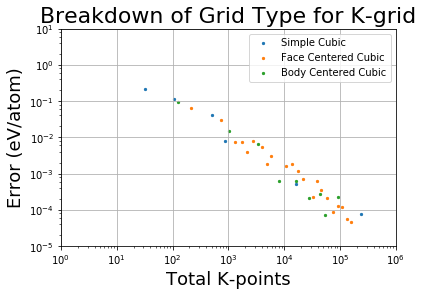

In [156]:
plt.scatter(al_sc[:,0],al_sc[:,1],label="Simple Cubic",s=5)
plt.scatter(al_fcc[:,0],al_fcc[:,1],label="Face Centered Cubic",s=5)
plt.scatter(al_bcc[:,0],al_bcc[:,1],label="Body Centered Cubic",s=5)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-5,10)
plt.xlim(1E0,1E6)
plt.legend()
plt.grid()
plt.title("Breakdown of Grid Type for K-grid",fontsize=22)
plt.ylabel("Error (eV/atom)",fontsize=18)
plt.xlabel("Total K-points",fontsize=18)
plt.savefig('/Users/wileymorgan/Desktop/Al_grid_type.pdf')
plt.show()

In [226]:
ks_u = []
m_j_ks_all = []
f = open('../data2/Si_1/Si_j_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    if int(row[0]) not in ks_u:
        ks_u.append(int(row[0]))
        if abs(float(row[1])) >0:
            m_j_ks_all.append([int(row[0]),abs(float(row[1]))])
m_j_ks_all.sort(key=lambda x: x[0])
m_j_ks_all = np.array(m_j_ks_all)

In [42]:
sc_full = []
bcc_full = []
fcc_full = []
all_grids = []

f = open('../data2/Si_by_grid/sc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    sc_full.append([int(row[0]),float(row[1])])
    if float(row[1]) > 1E-10:
        all_grids.append([int(row[0]),float(row[1])])
    
f = open('../data2/Si_by_grid/bcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    bcc_full.append([int(row[0]),float(row[1])])
    if float(row[1]) > 1E-10:
        all_grids.append([int(row[0]),float(row[1])])
    
f = open('../data2/Al_by_grid/bcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
Al_bcc_full = []
for row in reader:
    Al_bcc_full.append([int(row[0]),float(row[1])])
    
f = open('../data2/Al_by_grid/fcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
Al_fcc_full = []
for row in reader:
    Al_fcc_full.append([int(row[0]),float(row[1])])
    
f = open('../data2/Al_by_grid/sc_conv.csv')
reader = csv.reader(f,delimiter='\t')
Al_sc_full = []
for row in reader:
    Al_sc_full.append([int(row[0]),float(row[1])])
#    if float(row[1]) > 1E-10:
#        all_grids.append([int(row[0]),float(row[1])])
    
f = open('../data2/Si_by_grid/fcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    fcc_full.append([int(row[0]),float(row[1])])
    if float(row[1]) > 1E-10:
        all_grids.append([int(row[0]),float(row[1])])
    
all_grids.sort(key=lambda x: x[0])
sc_full = np.array(sc_full)
bcc_full = np.array(bcc_full)
fcc_full = np.array(fcc_full)
all_grids = np.array(all_grids)
Al_bcc_full = np.array(Al_bcc_full)
Al_fcc_full = np.array(Al_fcc_full)
Al_sc_full = np.array(Al_sc_full)

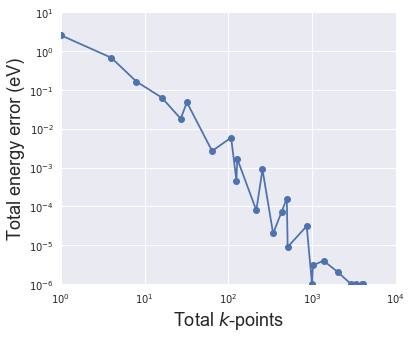

In [314]:
plt.figure(figsize=(6,5))
plt.plot(all_grids[:,0],all_grids[:,1],marker='o')
#plt.plot(m_j_ks_all[:,0],m_j_ks_all[:,1])
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,10)
plt.xlim(1E0,1E4)
plt.legend()
#plt.grid()
#plt.title("Si convergence",fontsize=22)
plt.ylabel("Total energy error (eV)",fontsize=18)
plt.xlabel("Total $k$-points",fontsize=18)
plt.savefig('/Users/wileymorgan/Desktop/Si_all_together.pdf')
plt.show()

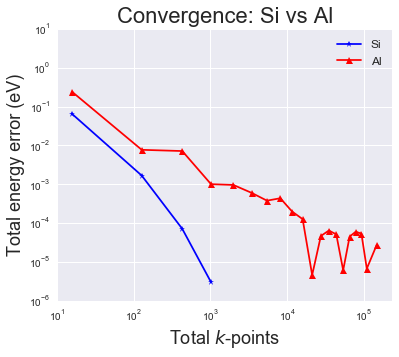

In [102]:
plt.figure(figsize=(6,5))
Si_full = np.array([i for i in bcc_full if i[1]>1E-7])
Al_full = np.array([i for i in Al_bcc_full if i[1]>1E-7])
#plt.plot(sc_full[:,0],sc_full[:,1],label="Simple Cubic",c='g',marker='^')
#plt.plot(fcc_full[:,0],fcc_full[:,1],label="Face Centered Cubic",c='saddlebrown',marker='s')
plt.plot(Si_full[:,0],Si_full[:,1],label="Si",c='b',marker='*')
plt.plot(Al_full[:,0],Al_full[:,1],label="Al",c='r',marker='^')
#plt.plot(sc[:,0],sc[:,1],label="Simple Cubic")
#plt.plot(fcc[:,0],fcc[:,1],label="Face Centered Cubic")
#plt.plot(bcc[:,0],bcc[:,1],label="Body Centered Cubic")
#plt.plot(m_j_ks_all[:,0],m_j_ks_all[:,1])
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,10)
#plt.xlim(1E0,1E4)
plt.legend(fontsize=12)
#plt.grid()
plt.title("Convergence: Si vs Al",fontsize=22)
plt.ylabel("Total energy error (eV)",fontsize=18)
plt.xlabel("Total $k$-points",fontsize=18)
plt.savefig('../plots/Al_vs_Si.pdf')
plt.show()

In [322]:
C_sc_full = []
C_bcc_full = []
C_fcc_full = []
C_all_grids = []

f = open('../data2/C_1/sc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    C_sc_full.append([int(row[0]),float(row[1])])
    if float(row[1]) > 1E-10:
        C_all_grids.append([int(row[0]),float(row[1])])
    
f = open('../data2/C_1/bcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    C_bcc_full.append([int(row[0]),float(row[1])])
    if float(row[1]) > 1E-10:
        C_all_grids.append([int(row[0]),float(row[1])])
    
f = open('../data2/C_1/fcc_conv.csv')
reader = csv.reader(f,delimiter='\t')
for row in reader:
    C_fcc_full.append([int(row[0]),float(row[1])])
    if float(row[1]) > 1E-10:
        C_all_grids.append([int(row[0]),float(row[1])])
    
C_all_grids.sort(key=lambda x: x[0])
C_sc_full = np.array(C_sc_full)
C_bcc_full = np.array(C_bcc_full)
C_fcc_full = np.array(C_fcc_full)
C_all_grids = np.array(C_all_grids)

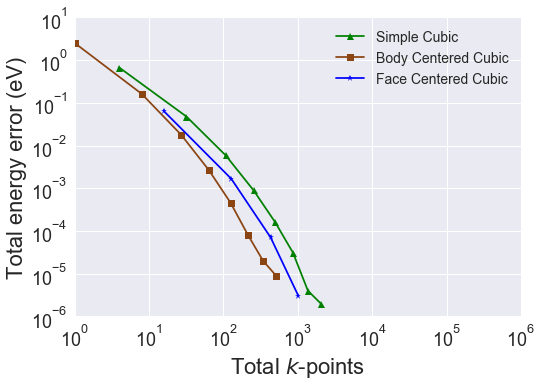

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)
#plt.figure(figsize=(6,5))
ax.plot(sc_full[:8,0],sc_full[:8,1],label="Simple Cubic",c='g',marker='^')
ax.plot(fcc_full[:8,0],fcc_full[:8,1],label="Body Centered Cubic",c='saddlebrown',marker='s')
ax.plot(bcc_full[:4,0],bcc_full[:4,1],label="Face Centered Cubic",c='b',marker='*')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,10)
plt.xlim(1E0,1E6)
plt.legend(fontsize=14)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 

#plt.grid()
#plt.title("Al Convergence by Grid Type",fontsize=22)
plt.ylabel("Total energy error (eV)",fontsize=22)
plt.xlabel("Total $k$-points",fontsize=22)
plt.savefig('../plots/Si_grid_type.pdf',bbox_inches="tight")
plt.show()

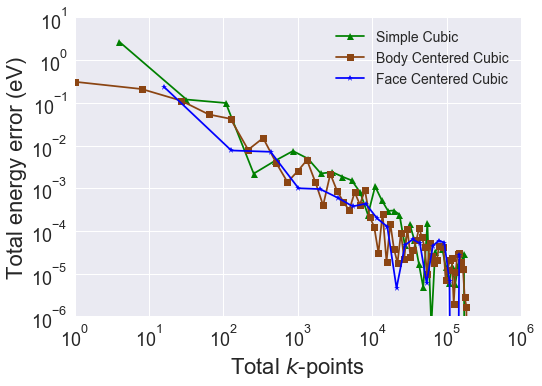

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)
#plt.figure(figsize=(6,5))
ax.plot(Al_sc_full[:,0],Al_sc_full[:,1],label="Simple Cubic",c='g',marker='^')
ax.plot(Al_fcc_full[:,0],Al_fcc_full[:,1],label="Body Centered Cubic",c='saddlebrown',marker='s')
ax.plot(Al_bcc_full[:,0],Al_bcc_full[:,1],label="Face Centered Cubic",c='b',marker='*')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1E-6,10)
plt.xlim(1E0,1E6)
plt.legend(fontsize=14)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 

#plt.grid()
#plt.title("Al Convergence by Grid Type",fontsize=22)
plt.ylabel("Total energy error (eV)",fontsize=22)
plt.xlabel("Total $k$-points",fontsize=22)
plt.savefig('../plots/Al_grid_type.pdf',bbox_inches="tight")
plt.show()

In [12]:
def get_mean_data_full(method,elements,sub_method=None):
    """Gathers the convergence data for the given method, element, 
    and sub-method, i.e. 'sc' for the Froyen method, and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different k-point density. The dataframe also
    contains the mean error per density and numbder of instances 
    the density occures.
    
    Args:
        methad (str): "Froyen", "Mueller", or "Aflow"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    for el in elements:
        if el in ["Ti","Y","Re"]:
            sizes = range(1,8)
        else:
            sizes = range(1,12)
            
        for i in sizes:
            data = [[0.0,0.0]]
            kpd = []
            if sub_method is None:
                f = open("../data2/{0}/{1}_conv/{2}_atom_kpd_conv.csv".format(method,el,i),"r")
            else:
                f = open("../data2/{0}/{1}_conv/{2}_{3}_atom_kpd_conv.csv".format(method,el,i,sub_method),"r")
            reader = csv.reader(f,delimiter='\t')
            for row in reader:
                if float(row[0]) in kpd and float(row[1]) != 0:
                    loc = kpd.index(float(row[0]))
                    data[loc][1] = (data[loc][1]+float(row[1]))/2.
                elif float(row[1]) != 0:
                    kpd.append(float(row[0]))
                    point = [float(row[0]),float(row[1])]
                    data.append(point)
                    
            data = np.array(data)
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])#,columns=[str(i)+' atom'])    
            else:
                print("Method: {0}, element: {1}, size: {2}".format(method,el,i))
                
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df

    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf